This notebook assumes you are familiar with Convolutional Neural Networks and Few Shot Learning using Siamese Networks. Therefore it does not contain analytical explanation of the model's training and testing stages. The preset episodes are 5 way- 1 shot but this can be modified during the evaluation stage when creating the episodes.

Mount Google Drive and Import Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install rarfile
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Extract CUB .rar file and create training and testing folders

In [ ]:
import rarfile
import os

# Provide the path to the .rar file
rar_file_path = '/content/drive/MyDrive/cub.rar'
extract_dir = '/content/extracted_files'  # Directory where you want to extract files

# Ensure the extraction directory exists
os.makedirs(extract_dir, exist_ok=True)

# Open the .rar file and extract it
with rarfile.RarFile(rar_file_path) as rf:
    rf.extractall(path=extract_dir)

# Verify the contents
!ls /content/extracted_files


images


In [ ]:
import os
import shutil
import random

original_dir = '/content/extracted_files/images'  # Update with your dataset directory
train_dir = '/content/cub_train'  # Directory for training images
test_dir = '/content/cub_test'    # Directory for testing images

Split classes for training and testing. This notebook uses 60 classes for training and 20 classes for testing.

In [ ]:
# List all the class folders
all_classes = os.listdir(original_dir)

# Select 80 random classes
selected_classes = random.sample(all_classes, 80)

# Split into 60 for training and 20 for testing
train_classes = selected_classes[:60]
test_classes = selected_classes[60:]


In [ ]:
# Copy selected training classes to the train directory
for cls in train_classes:
    src_path = os.path.join(original_dir, cls)
    dest_path = os.path.join(train_dir, cls)
    shutil.copytree(src_path, dest_path)

# Copy selected testing classes to the test directory
for cls in test_classes:
    src_path = os.path.join(original_dir, cls)
    dest_path = os.path.join(test_dir, cls)
    shutil.copytree(src_path, dest_path)
    # List the contents of the train and test directories to verify the split
print("Training Classes:", os.listdir(train_dir))
print("Testing Classes:", os.listdir(test_dir))



Training Classes: ['081.Pied_Kingfisher', '156.White_eyed_Vireo', '041.Scissor_tailed_Flycatcher', '112.Great_Grey_Shrike', '194.Cactus_Wren', '045.Northern_Fulmar', '100.Brown_Pelican', '155.Warbling_Vireo', '046.Gadwall', '019.Gray_Catbird', '068.Ruby_throated_Hummingbird', '095.Baltimore_Oriole', '104.American_Pipit', '141.Artic_Tern', '105.Whip_poor_Will', '144.Common_Tern', '032.Mangrove_Cuckoo', '071.Long_tailed_Jaeger', '030.Fish_Crow', '181.Worm_eating_Warbler', '079.Belted_Kingfisher', '090.Red_breasted_Merganser', '076.Dark_eyed_Junco', '111.Loggerhead_Shrike', '177.Prothonotary_Warbler', '184.Louisiana_Waterthrush', '002.Laysan_Albatross', '125.Lincoln_Sparrow', '004.Groove_billed_Ani', '060.Glaucous_winged_Gull', '084.Red_legged_Kittiwake', '023.Brandt_Cormorant', '159.Black_and_white_Warbler', '088.Western_Meadowlark', '124.Le_Conte_Sparrow', '122.Harris_Sparrow', '109.American_Redstart', '138.Tree_Swallow', '131.Vesper_Sparrow', '170.Mourning_Warbler', '137.Cliff_Swallow'

In [ ]:
import os

def count_subdirectories(directory):
    subdirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    return len(subdirs)

# Example usage
directory = '/content/cub_train'
total_subdirectories = count_subdirectories(directory)
print(f"Total number of subdirectories in '{directory}': {total_subdirectories}")

Total number of subdirectories in '/content/cub_train': 60


Episode Generation. You can set the number of support samples per class and also the number of classes inside every episode.

In [ ]:
import os
import random

def generate_episode(data_dir, num_classes, num_support_samples , seed):
    """
    Generate a single episode with a given number of pairs, with reproducibility using a seed.

    Args:
        data_dir (str): Path to the dataset directory. It should contain subdirectories for each class.
        num_classes (int): Number of classes to select for the episode.
        num_support_samples (int): Number of support samples to select per class.
        num_pairs (int): Total number of pairs to generate in the episode.
        seed (int, optional): Seed for reproducibility.

    Returns:
        list: A list of tuples (img1_path, img2_path) for the episode.
        list: A list of labels (1 for positive pairs, 0 for negative pairs).
    """
    if seed is not None:
        random.seed(seed)

    # Get list of classes
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    # Randomly select num_classes
    selected_classes = random.sample(classes, num_classes)

    # Dictionary to hold images for selected classes
    selected_images = {}
    for cls in selected_classes:
        images = [os.path.join(data_dir, cls, img) for img in os.listdir(os.path.join(data_dir, cls))]
        selected_images[cls] = images

    # Select multiple support samples per class
    support_samples = []
    for cls, images in selected_images.items():
        selected_support_images = random.sample(images, num_support_samples)
        for support_image in selected_support_images:
            support_samples.append((support_image, cls))

    # Select one query image from one of the selected classes
    query_class = random.choice(selected_classes)
    query_image = random.choice(selected_images[query_class])  # query path

    # Create pairs
    pairs = []
    labels = []

    # Generate pairs between query image and each support image
    for support_image, support_class in support_samples:
        pairs.append((query_image, support_image))
        labels.append(1 if support_class == query_class else 0)

    return pairs, labels

# Example usage
#data_dir = '/content/directory/test'
#episode_pairs, episode_labels = generate_episode(data_dir, num_classes=5, num_support_samples=3, seed=42)

#print("Pairs:")
#for p in episode_pairs:
 #   print(p)
#print("Labels:")
#print(episode_labels)


Pair Generation

In [ ]:
import os
import random
from itertools import combinations
import numpy as np

def create_siamese_pairs(data_dir, num_positive_pairs, num_negative_pairs):
    """
    Create pairs of images for a Siamese network from a dataset with a given structure.

    Args:
        data_dir (str): Path to the dataset directory. It should contain subdirectories for each class.
        num_positive_pairs (int): Number of positive pairs to generate per class.
        num_negative_pairs (int): Total number of negative pairs to generate.

    Returns:
        tuple: A tuple containing two numpy arrays:
               - pairs: Array of tuples (img1_path, img2_path).
               - labels: Array of labels (1 for positive pairs, 0 for negative pairs).
    """

    # Get list of classes
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    unique_labels = set(classes)  # Using set to ensure uniqueness
    num_unique_labels = len(unique_labels)

    # Print the unique labels and their count
    print("Unique labels:", unique_labels)
    print("Number of unique labels:", num_unique_labels)

    # Store images for each class
    class_images = {}
    for cls in classes:
        class_images[cls] = [os.path.join(data_dir, cls, img) for img in os.listdir(os.path.join(data_dir, cls))]

    # Create positive pairs
    pairs = []
    labels = []
    for cls, images in class_images.items():
        if len(images) < 2:
            continue  # Skip classes with less than 2 images
        # Generate all possible combinations of images within the same class
        pos_pairs = list(combinations(images, 2))
        random.shuffle(pos_pairs)  # Shuffle to ensure randomness
        selected_pos_pairs = pos_pairs[:num_positive_pairs]
        pairs.extend([(img1, img2) for img1, img2 in selected_pos_pairs])
        labels.extend([1] * len(selected_pos_pairs))

    # Create negative pairs
    all_images = [(cls, img) for cls, imgs in class_images.items() for img in imgs]
    random.shuffle(all_images)
    neg_pairs = set()
    while len(neg_pairs) < num_negative_pairs:
        cls1, img1 = random.choice(all_images)
        cls2, img2 = random.choice(all_images)
        if cls1 != cls2:
            neg_pairs.add((img1, img2))

    pairs.extend(neg_pairs)
    labels.extend([0] * len(neg_pairs))

    # Convert to numpy arrays
    pairs_array = np.array(pairs)
    labels_array = np.array(labels)

    return pairs_array, labels_array

# Example usage:
#data_directory = '/content/directory/train'
#pairs, labels = create_siamese_pairs(data_directory)

#print(pairs)  # Array of pairs (img1_path, img2_path)
#print(labels) # Array of labels



Function to visualize the pairs after creating an episode. We need to make sure that pairs that contain images from the same class have a label of '1' (positive pairs) and pairs that contain images that belong to different classes have a label of '0' (negative pairs).

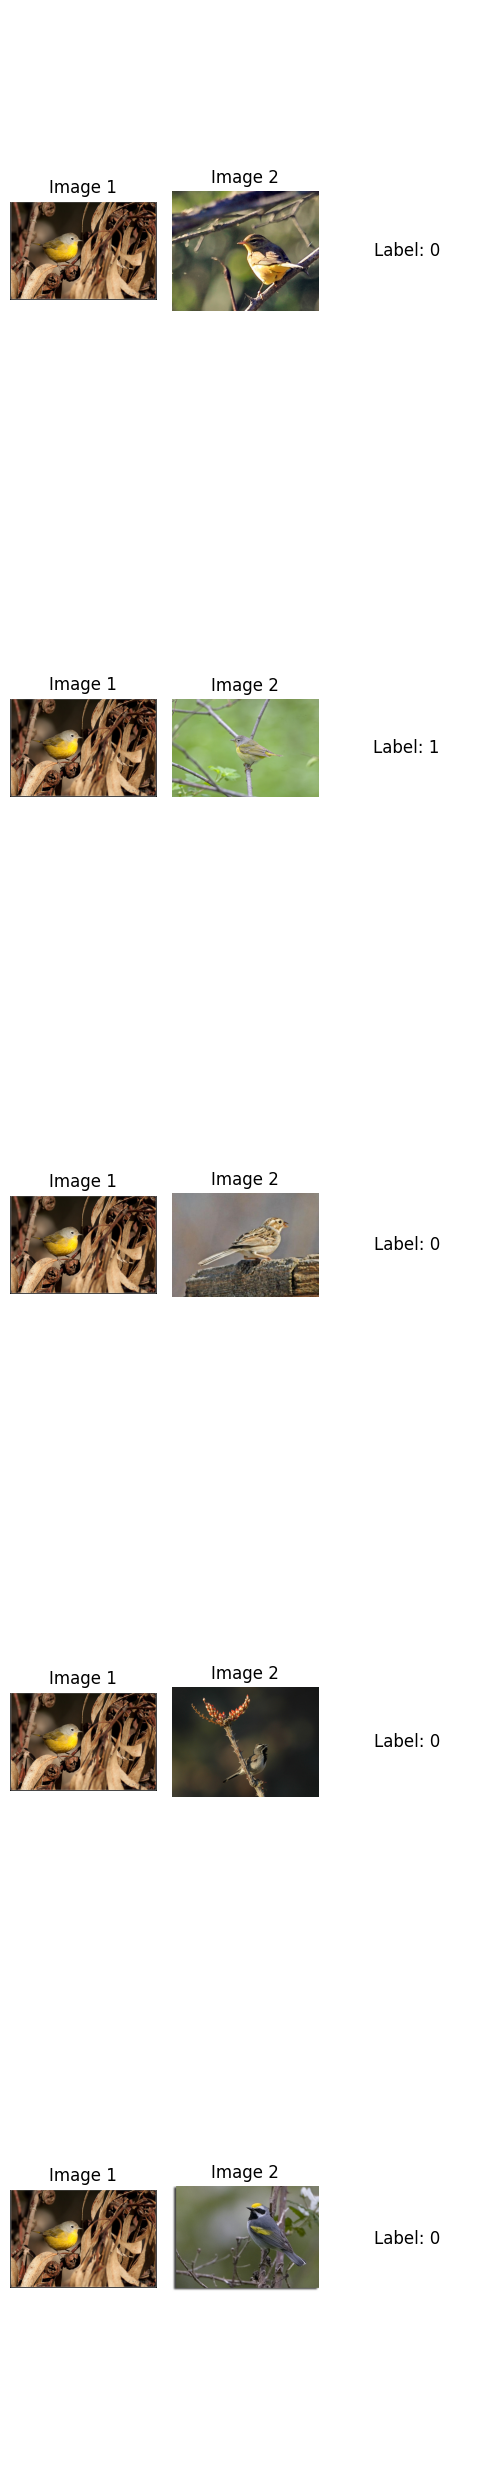

[('/content/cub_test/172.Nashville_Warbler/Nashville_Warbler_0121_167078.jpg', '/content/cub_test/174.Palm_Warbler/Palm_Warbler_0015_169626.jpg'), ('/content/cub_test/172.Nashville_Warbler/Nashville_Warbler_0121_167078.jpg', '/content/cub_test/172.Nashville_Warbler/Nashville_Warbler_0040_167454.jpg'), ('/content/cub_test/172.Nashville_Warbler/Nashville_Warbler_0121_167078.jpg', '/content/cub_test/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0075_797251.jpg'), ('/content/cub_test/172.Nashville_Warbler/Nashville_Warbler_0121_167078.jpg', '/content/cub_test/114.Black_throated_Sparrow/Black_Throated_Sparrow_0078_107298.jpg'), ('/content/cub_test/172.Nashville_Warbler/Nashville_Warbler_0121_167078.jpg', '/content/cub_test/166.Golden_winged_Warbler/Golden_Winged_Warbler_0066_794803.jpg')]
[0, 1, 0, 0, 0]


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def visualize_pairs(pairs, labels):
    """
    Visualize image pairs alongside their labels.

    Args:
        pairs (list): List of tuples where each tuple contains two image paths.
        labels (list): List of labels corresponding to each pair (1 for positive, 0 for negative).
    """
    num_pairs = len(pairs)
    fig, axes = plt.subplots(num_pairs, 3, figsize=(5, num_pairs * 5))

    for i, (img1_path, img2_path) in enumerate(pairs):
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)
        label = labels[i]

        axes[i, 0].imshow(img1)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image 1')

        axes[i, 1].imshow(img2)
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Image 2')

        axes[i, 2].text(0.5, 0.5, 'Label: {}'.format(label), fontsize=12, ha='center', va='center')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
data_dir = '/content/cub_test'
pairs, labels = generate_episode(data_dir, num_classes=5, num_support_samples=1 , seed=None)
visualize_pairs(pairs, labels)
print(pairs)
print(labels)

Create custom dataset that converts the 2 paths of every pair to the actual images stored in our folders,along with the corresponding label.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image


class SiameseNetworkDataset(Dataset):
    def __init__(self, pairs, labels, transform):
        self.pairs = pairs
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        img1_path, img2_path = self.pairs[index]
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB') ##Convert path to actual image ##

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        label = torch.FloatTensor([self.labels[index]])
        return img1, img2, label

    def __len__(self):
        return len(self.pairs)

# Example transforms
transform = transforms.Compose([
    transforms.Resize((84,84)),
    transforms.ToTensor()
])

Create the model. During training and testing we use 2 identical CNN's that will calculate the feature vectors of both images for every pair. The backbone used to extract features is ResNet-34.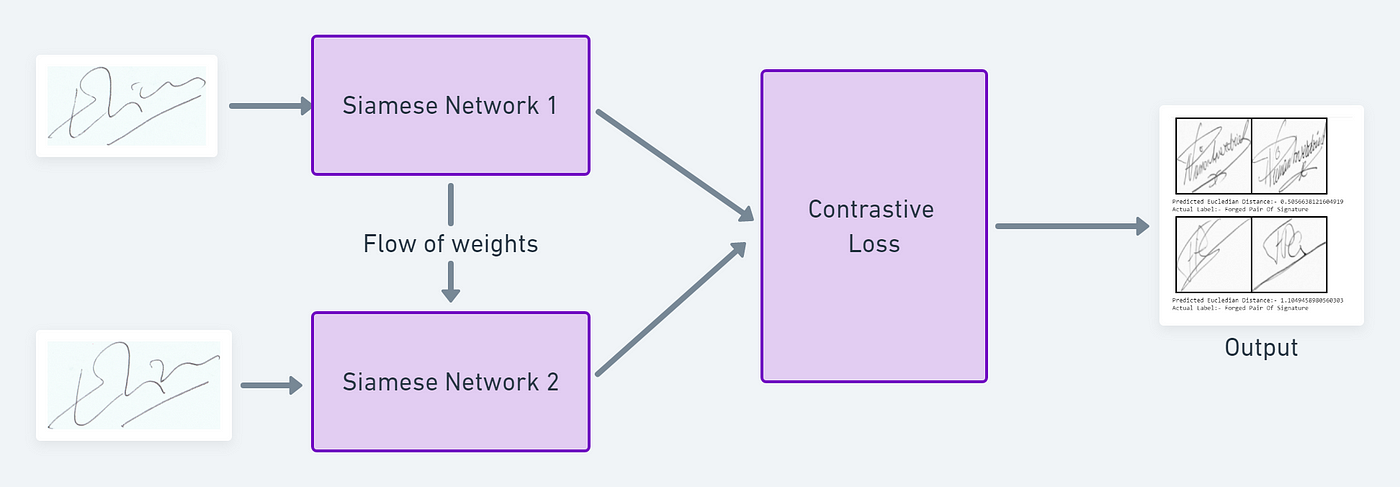

In [ ]:
from torchvision.models import resnet18,resnet34,efficientnet_b0
import torch.nn.functional as F
class SiameseNetwork(nn.Module):
    def __init__(self, pretrained=True):
        super(SiameseNetwork, self).__init__()
        resnet = resnet34(pretrained=pretrained)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # Remove the last classification layer- we only need the backbone

    def forward_one(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.normalize(x, p=2, dim=1)  # L2 normalize the embeddings
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        #print('Shape after feature extraction: ',output1.shape)
        return output1,output2

In [ ]:
model = SiameseNetwork().cuda()
##for name, param in model.named_parameters():
   # print(f"{name}: requires_grad={param.requires_grad}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Contrastive l.f. This loss function aims to minimize the distance between positive pairs and maximize the distance between negative pairs.

In [ ]:
import torch
import torch.nn as nn

class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Compute the Euclidean distance between the two embeddings
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2, keepdim=True)
        #print(euclidean_distance)

        # Compute the contrastive loss
        loss_contrastive = torch.mean(
            label * torch.pow(euclidean_distance, 2) +  # For similar pairs
            (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)  # For dissimilar pairs
        )

        return loss_contrastive



Train Network after placing pairs inside data loader. You can adjust the learning rate,number of epochs and finally the margin which is a hyperparameter that defines the minimum desired distance between the 2 images of a negative pair. For example, if you set the margin to 1.25 the weights of the model are updated so that for every negative pair, the euclidean distance calculated between the 2 feature vectors should be at least 1.25.

In [ ]:
def train_siamese_network(model, dataloader, num_epochs=1):
    criterion = ContrastiveLoss(margin=1.25)
    optimizer = optim.Adam(model.parameters(), lr=5e-5)
    model.train()

    for epoch in range(num_epochs):
        for i, (img1, img2, label) in enumerate(dataloader):
            img1, img2, label = img1.cuda(),img2.cuda(),label.cuda()

            optimizer.zero_grad()
            out1,out2 = model(img1, img2)
            loss = criterion(out1,out2, label)
            loss.backward()
            optimizer.step()

            if i % 240 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], Loss: {loss.item():.4f}")

# Instantiate and train the model
data_directory = '/content/cub_train'
pairs, labels = create_siamese_pairs(data_directory,num_positive_pairs=300,num_negative_pairs=18000)
dataset = SiameseNetworkDataset(pairs, labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
num_batches = len(dataloader)

print(f"Number of batches: {num_batches}")
train_siamese_network(model, dataloader)

Unique labels: {'144.Common_Tern', '122.Harris_Sparrow', '111.Loggerhead_Shrike', '019.Gray_Catbird', '184.Louisiana_Waterthrush', '138.Tree_Swallow', '185.Bohemian_Waxwing', '004.Groove_billed_Ani', '060.Glaucous_winged_Gull', '156.White_eyed_Vireo', '068.Ruby_throated_Hummingbird', '112.Great_Grey_Shrike', '113.Baird_Sparrow', '043.Yellow_bellied_Flycatcher', '155.Warbling_Vireo', '181.Worm_eating_Warbler', '079.Belted_Kingfisher', '140.Summer_Tanager', '109.American_Redstart', '076.Dark_eyed_Junco', '081.Pied_Kingfisher', '177.Prothonotary_Warbler', '170.Mourning_Warbler', '142.Black_Tern', '096.Hooded_Oriole', '123.Henslow_Sparrow', '067.Anna_Hummingbird', '105.Whip_poor_Will', '148.Green_tailed_Towhee', '125.Lincoln_Sparrow', '189.Red_bellied_Woodpecker', '193.Bewick_Wren', '033.Yellow_billed_Cuckoo', '088.Western_Meadowlark', '028.Brown_Creeper', '194.Cactus_Wren', '032.Mangrove_Cuckoo', '056.Pine_Grosbeak', '159.Black_and_white_Warbler', '141.Artic_Tern', '030.Fish_Crow', '162.C

Evaluate model using the test episodes. For every episode we calculate the distance between the feature vector of the query sample and every feature vector of the support samples. The query sample is assigned to the class whose support sample has the smallest distance in the feature space because it presents the biggest similarity. If you change the number of support samples you should change the 'if pair count==x' instruction and change x to the number of support samples you have chosen.

In [ ]:

import torch
from torchvision import transforms
from PIL import Image
import torch
from torchvision import transforms
from PIL import Image

def evaluate_siamese_network(model, pairs, labels, transform, device):
    model.eval()

    cumulative_scores = []  # List to store cumulative scores for each group of x samples
    current_score = 0.0  # Variable to keep track of the score within a group
    pair_count = 0  # Counter for the current pair in the group
    group_labels = []  # List to store labels for each group of x pairs

    with torch.no_grad():
        for index, (img1_path, img2_path) in enumerate(pairs):
            # Load and transform images
            img1 = Image.open(img1_path).convert('RGB')
            img2 = Image.open(img2_path).convert('RGB')
            img1 = transform(img1).unsqueeze(0).to(device)
            img2 = transform(img2).unsqueeze(0).to(device)

            # Forward pass through the network
            output1, output2 = model(img1, img2)
            distance = torch.nn.functional.pairwise_distance(output1, output2, keepdim=True)
            #print(distance)

            # Calculate the score as 1/distance and add to the current group's score
            score = 1 / distance.item()
            current_score += score
            pair_count += 1

            # Check if we've reached the amount of pairs per class- if you change the number of support samples per class change the '1' below with the new number of samples per class #
            if pair_count == 1:
                # Store the cumulative score and corresponding labels for the group
                cumulative_scores.append(current_score)
                group_labels.append(labels[index])  # We use the label of the last pair in the group
                current_score = 0.0
                pair_count = 0

    best_group_index = cumulative_scores.index(max(cumulative_scores))

    # Check if the highest score corresponds to the group with label 1
    is_correct = group_labels[best_group_index] == 1

    return best_group_index, cumulative_scores, is_correct

# Example usage
data_dir = '/content/cub_test'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((84,84))
])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate and evaluate multiple episodes
correct = 0
wrong = 0
from tqdm import tqdm
for i in tqdm(range(7500), desc="Processing episodes"):
    episode_pairs, binary_labels = generate_episode(data_dir, num_classes=5, num_support_samples=1, seed=i)
    best_group_index, cumulative_scores, is_correct = evaluate_siamese_network(model, episode_pairs, binary_labels, transform, device)

    if is_correct:
        correct += 1
    else:
        wrong += 1

print(f"\nTotal Correct: {correct}")
print(f"Total Wrong: {wrong}")
print('Clasification Accuracy: ',round((correct/(correct+wrong)),4))



In [ ]:
correct = 0
wrong = 0
from tqdm import tqdm
for i in tqdm(range(7500), desc="Processing episodes"):
    episode_pairs, binary_labels = generate_episode(data_dir, num_classes=5, num_support_samples=1, seed=i)
    best_group_index, cumulative_scores, is_correct = evaluate_siamese_network(model, episode_pairs, binary_labels, transform, device)

    if is_correct:
        correct += 1
    else:
        wrong += 1

print(f"\nTotal Correct: {correct}")
print(f"Total Wrong: {wrong}")